In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv
/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00005.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00057.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00020.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00072.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00040.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00043.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00010.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00071.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/image

In [2]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy as sp
import soundfile as sf

# Loading Select Data

In [3]:
# There are 10 different Genres in the GTZAN Music Genre Dataset
# Let us load the first example wav file of each
blues_file = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav"
classical_file = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00000.wav"
country_file = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/country/country.00000.wav"
disco_file = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00000.wav"
hiphop_file = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/hiphop/hiphop.00000.wav"
jazz_file = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00000.wav"
metal_file = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00000.wav"
pop_file = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/pop/pop.00000.wav"
reggae_file = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/reggae/reggae.00000.wav"
rock_file = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/rock/rock.00000.wav"

In [4]:
# we can play any file as :
ipd.Audio(rock_file)

These files also have vocals in them, before we try the FT on these audios, lets seperate the vocals out of the audio files. We can do this using librosa

In [66]:
# loading the files:
# the sample rate sr remains the same, so lets only take it once
blues, sr = librosa.load(blues_file)
classical, _ = librosa.load(classical_file)
country, _ = librosa.load(country_file)
disco, _ = librosa.load(disco_file)
hiphop, _ = librosa.load(hiphop_file)
jazz, _ = librosa.load(jazz_file)
metal, _ = librosa.load(metal_file)
pop, _ = librosa.load(pop_file)
reggae, _ = librosa.load(reggae_file)
rock, _ = librosa.load(rock_file)

# Viewing the wave forms

In [34]:
def waveform(audio, title):
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 1, 1)
    
    librosa.display.waveplot(audio, alpha=0.5)
    plt.title(title)
    plt.ylim((-1,1))

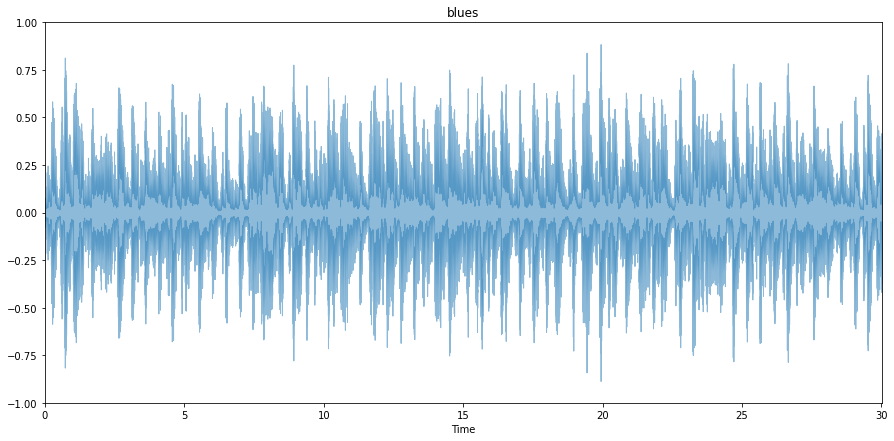

In [35]:
# blues:
waveform(blues, "blues")

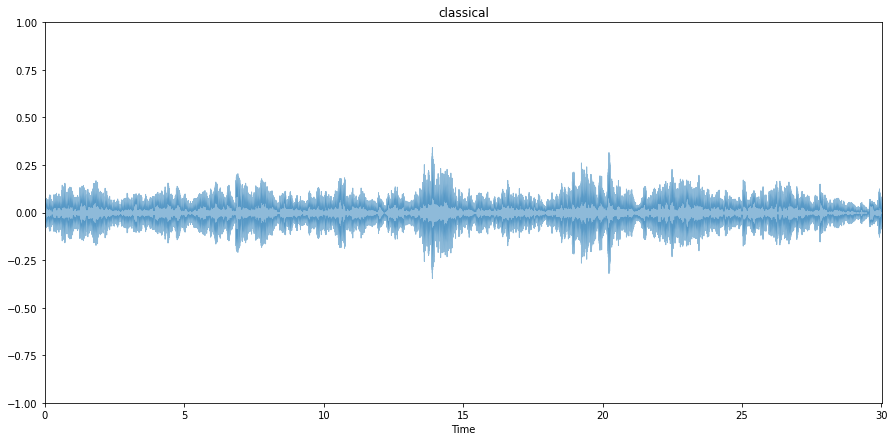

In [17]:
# classical:
waveform(classical, "classical")

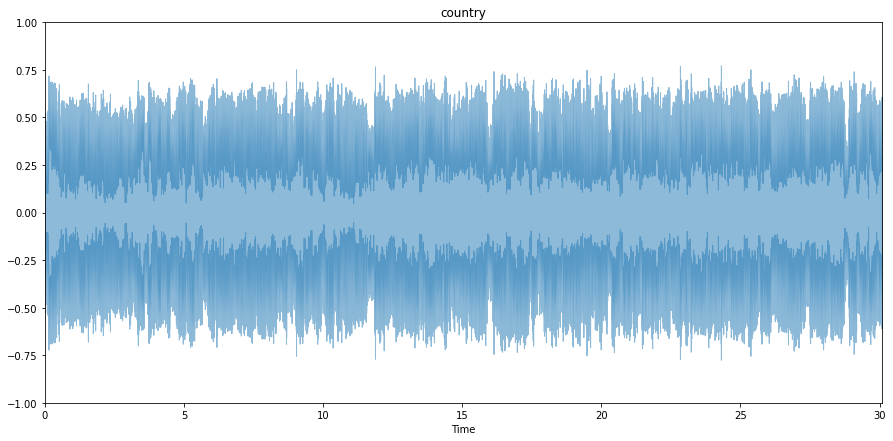

In [18]:
# country:
waveform(country, "country")

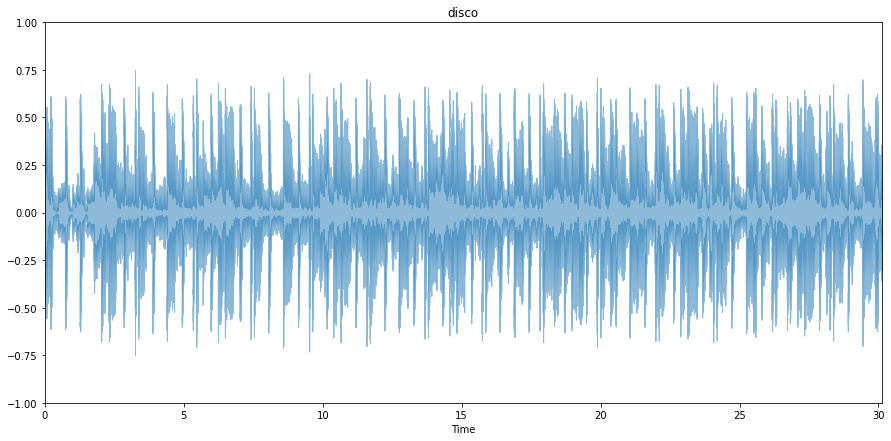

In [19]:
# disco:
waveform(disco, "disco")

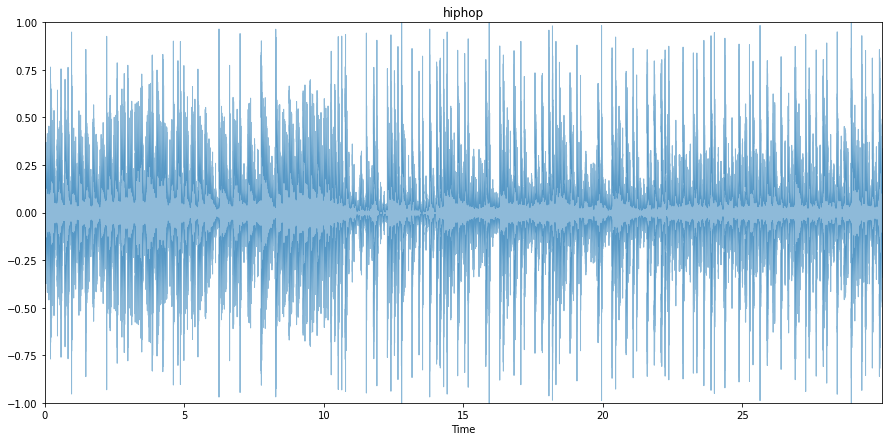

In [20]:
# hiphop:
waveform(hiphop, "hiphop")

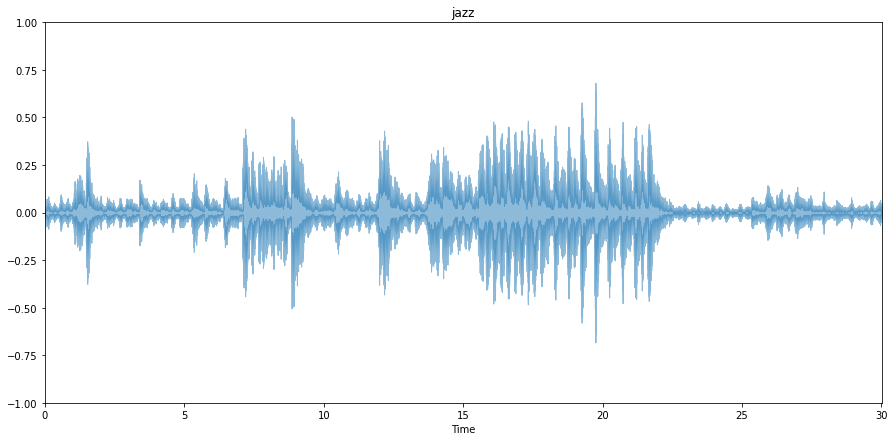

In [21]:
# jazz:
waveform(jazz, "jazz")

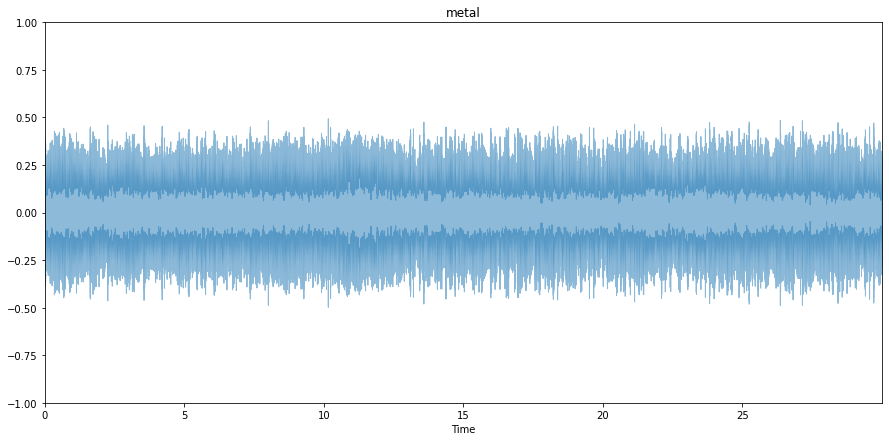

In [22]:
# metal:
waveform(metal, "metal")

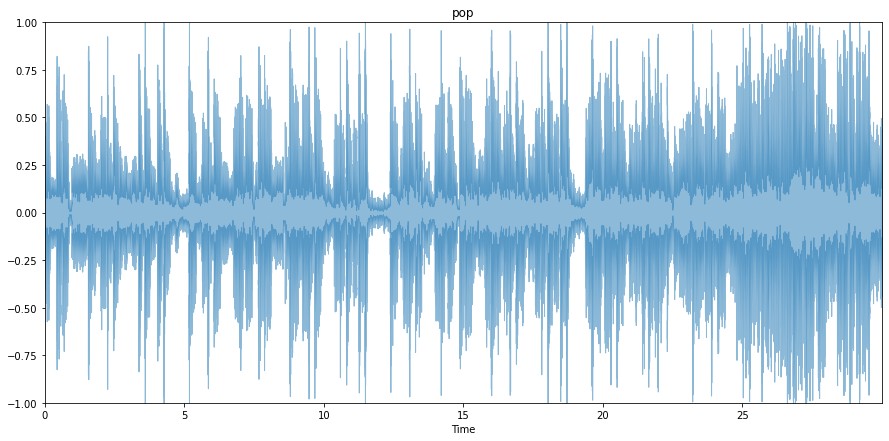

In [23]:
# pop:
waveform(pop, "pop")

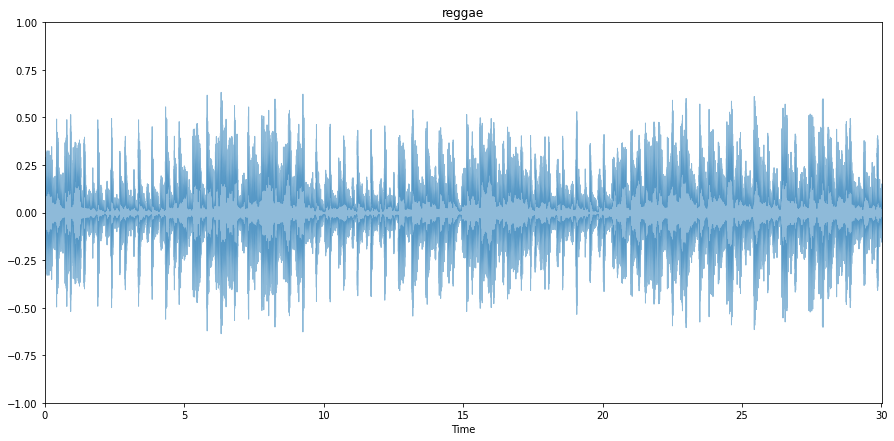

In [24]:
# reggae:
waveform(reggae, "reggae")

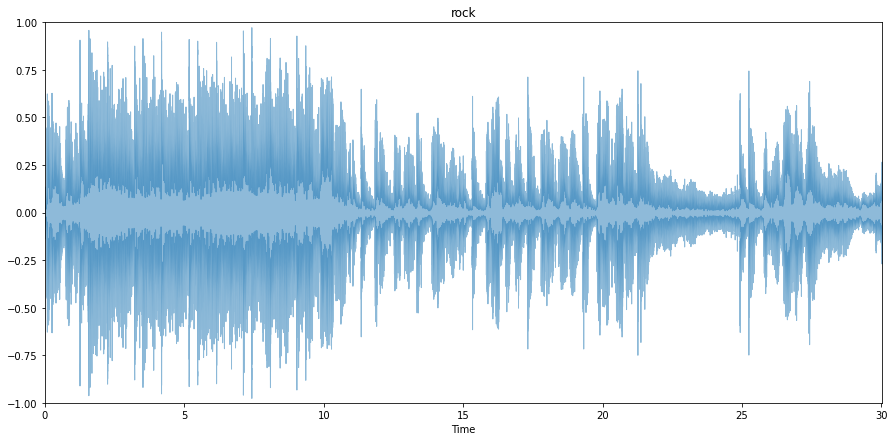

In [25]:
# rock:
waveform(rock, "rock")

# Seperating Audio Files

In [ ]:
pip install spleeter

In [86]:
!spleeter separate ../input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav -o output/

INFO:spleeter:File output/blues.00000/vocals.wav written succesfully
INFO:spleeter:File output/blues.00000/accompaniment.wav written succesfully
Exception ignored in: <function Separator.__del__ at 0x7f63c5dbb0e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/spleeter/separator.py", line 135, in __del__
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 755, in close
AttributeError: 'NoneType' object has no attribute 'TF_CloseSession'


In [78]:
# a function to seperate vocals:
def seperate_vocals(y):
    # getting the magnitude and phase
    S_full, phase = librosa.magphase(librosa.stft(y))
    S_filter = librosa.decompose.nn_filter(S_full,
                                           aggregate=np.median,
                                           metric='cosine',
                                           width=int(librosa.time_to_frames(2, sr=sr)))
    
    S_filter = np.minimum(S_full, S_filter)
    
    margin_i, margin_v = 2, 10
    power = 2

    mask_i = librosa.util.softmask(S_filter,
                                   margin_i * (S_full - S_filter),
                                   power=power)

    mask_v = librosa.util.softmask(S_full - S_filter,
                                   margin_v * S_filter,
                                   power=power)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components
    S_foreground = mask_v * S_full
    S_background = mask_i * S_full
#     D_background = S_background * phase
    y_background = librosa.istft(S_background)
    
    return y_background

In [79]:
# getting instrumental and vocals seperated for the audios:
blues = seperate_vocals(blues)

In [80]:
blues

array([ 1.8061091e-05,  1.3590738e-05,  5.7468264e-06, ...,
       -1.0296232e-05, -7.4519317e-06, -6.2116910e-06], dtype=float32)

In [81]:
# saving the files
sf.write("blues_i.wav", blues, sr, 'PCM_24')

In [71]:
# first we check the blues file as is
ipd.Audio(blues_file)

In [82]:
# now we check the seperated vocals
ipd.Audio("./blues_i.wav")